# Exercise 4
In Exercise 1, you already applied permutation feature importance to estimate the importance of different features. In this exercise, you will now implement the algorithm yourself, as well as two other feature importance methods.

* Finish the exercise until 22/11/2023 17:00 German time.
* In order to gain a bonus point for this exercise, 4 of 5 tests should pass. We will manually check failed tests such that even if you managed to solve the exercise in a way that the tests do not pass, but it is still correct, you will still receive the bonus point.
* More details can be found in the README.md

IMPORTANT
* Do not add or delete cells from this notebook!
* Do not rename existing variables, in particular those ones for which assignments are missing!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Part 1: Permutation Feature Importance (PFI)

Permutation Feature Importance compares the performance of the model on the original data with the performance on perturbed data, where the dependence of the variable of interest with the target $Y$ is broken.

Here, we want to implement PFI ourselves. First, we start by loading some data and training a linear regression model on it:

In [3]:
df = pd.read_csv('extrapolation.csv', index_col=0)

X, y = df[df.columns[df.columns != 'y']], df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=2)

model = LinearRegression()
model.fit(X_train, y_train)

mse_test = mean_squared_error(y_test, model.predict(X_test))

print('MSE: {}'.format(mse_test))

MSE: 0.00972773357249966


Fill in the function *calculate_pfi()*, such that it iterates over the columns in X_test, and for each feature permutes the corresponding column using *np.random.permutation()* and calculates the corresponding PFI score for that feature based on the mean-squared-error loss.

In [4]:
def calculate_pfi(model, X_test, y_test, mse_test, seed):
    """Iterates over all features in X_test and calculates the corresponding PFI score based on one permutation.

    Args:
        model: trained model
        X_test: feature values of test data
        y_test: respective labels for test data
        mse_test: MSE on unpertubed test data
        seed: random seed to fix numpy random generator (only important for automatic testing here)

    Returns:
        results (list or 1D np.ndarray): PFI score for each feature in X_test
    """
    #init pfi
    np.random.seed(seed)
    pfi = []
    
    #loop through the features and permute
    for col in X_test.columns:
        X_permute = X_test.copy()
        X_permute[col] = np.random.permutation(X_permute[col])
        y_pred = model.predict(X_permute)
        mse_permute = mean_squared_error(y_test,y_pred)
        delta_L = mse_permute - mse_test
        pfi.append(delta_L)
        
    return pfi

The function is now called 10 times to get a mean and standard-deviation:

In [5]:
np.random.seed(42) # only important for automatic testing here
n_runs = 10
pfi = []
for _ in range(n_runs):
    pfi.append(calculate_pfi(model, X_test, y_test, mse_test, seed=np.random.randint(100)))
pfi_mean, pfi_std = np.mean(pfi, axis=0), np.std(pfi, axis=0)

We want to write a small plotting function to create a bar plot of the calculated scores per feature:

In [6]:
def plot_scores(feature_names, scores, title, scores_std=None):
    """Creates bar plot showing scores (including error bars) over features.

    Args:
        feature_names: feature names
        scores: (mean) scores per feature
        title: plot title
        scores_std: standard deviations of scores per feature

    Returns:
        fig (matplotlib.figure.Figure): final plot
    """
    fig = plt.figure()
    bar_width = 0.3
    plt.bar(feature_names,scores,width=bar_width)
    plt.errorbar(feature_names,scores,yerr=scores_std,linestyle = "None",color="black")
    plt.title(title)
    
    return fig

weights =  [-0.62950124  0.62976073  1.00191432  0.00220516]
bias =  0.004209214622817525


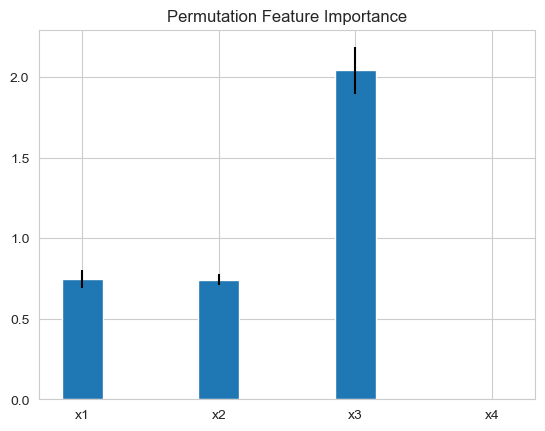

In [8]:
# plot pfi scores
pfi_plot = plot_scores(
    feature_names=X_test.columns,
    scores=pfi_mean,
    scores_std=pfi_std,
    title='Permutation Feature Importance')

print("weights = ", model.coef_)
print("bias = ",model.intercept_)

$X_3$ is the most important feature, with $X_1$ and $X_2$ sharing the second place. PFI considers $X_4$ to be irrelevant.

**Question:** Considering the different interpretation goals discussed in the lecture, what can we infer from the plot?

**Answer:** From the plot of PFI we can see that if we change the value of $X_1$, $X_2$, $X_3$, it will have an effect on the prediction, $X_3$ have the most effect on the prediction. If we print the weights and bias of the model, 

weights =  [-0.62950124  0.62976073  1.00191432  0.00220516]

bias =  0.004209214622817525

we can see that weights of $X_1$ and $X_2$ have the same magnitude but opposite signs, that means they will cancel out each other if they have the same value (linear relationship with $X_1$ = $X_2$).

### Pairplot

We now want to create a pairplot showing the pairwise scatterplots of the original feature $X_2$ with all remaining features and with $Y$, as well as the pairwise scatterplots of the corresponding perturbed variable $X_{2,\text{pert}}$ with all remaining features and with $Y$. For this, fill in the function *pairplot_comparison()*, which should pertube the feature values of $X_2$ (using *np.random.permutation()* again) and create the described scatter plots using **seaborn.pairplot()**. You should obtain 8 scatterplots in total.

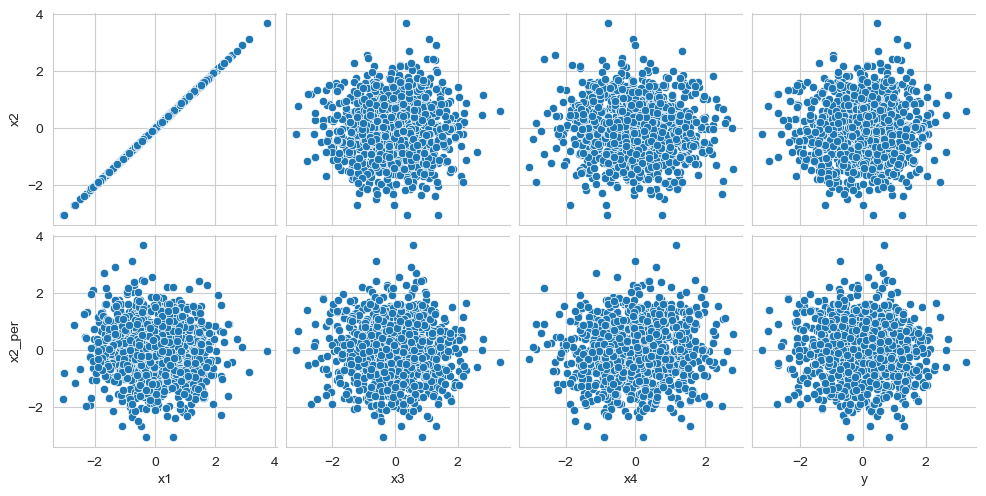

In [9]:
def pairplot_comparison(data, fname):
    """Creates pair plot showing the pairwise scatterplots of the original feature fname as well as the
    corresponding perturbed variable fname_pert with all remaining columns (features as well as response)
    in the data.

    Args:
        data: dataframe containing different features (and the response) in the columns
        fname: name of the feature

    Returns:
        pairplot (seaborn.axisgrid.PairGrid): final plot
    """
    fname_per = fname+"_per"
    data[fname_per] = np.random.permutation(data[fname])
    x_vars = [i for i in data.columns if i not in [fname,fname_per]]
    fig = sns.pairplot(data=data,x_vars=x_vars,y_vars=[fname,fname_per])
    return fig

pairplot = pairplot_comparison(data=df, fname='x2')

**Question:** What can be observed here regarding the permutation?

**Answer:** In the original datasets $X_1$ and $X_2$ have the linear relationship, in this case $X_2$ = $X_1$. That means they actually don't effect to the predictions. However, PFI shows that the importance of these two features is the same because we permute the $X_2$ randomly without a conditional distribution, that would "break" the relationship between $X_2$ and $X_1$.

# Part 2: Conditional Feature Importance (CFI)

Now we want to calculate Conditional Feature Importance. For this, we need to perform conditional sampling. An efficient, Pytorch-based implementation is given in a separate file (utils.py). In order to keep things clean, we only provide a small wrapper function here.

In [10]:
import utils

def sample_cond(f_select, f_cond, X_train, X_test, num_samples=1):
    """Samples feature values for features f_select conditioned on features f_cond.

    Args:
        f_select: selected features to be sampled
        f_cond: features to condition on
        X_train: feature values of train data, required for fitting the gaussian sampler
        X_test: feature values of test data
        num_samples: number of samples to be sampled

    Returns:
        sample_df (pd.DataFrame): dataframe containing the sampled feature values
    """
    dist = utils.GaussianConditionalEstimator()
    dist.fit(X_train[sorted(f_select)].to_numpy(), X_train[sorted(f_cond)].to_numpy())
    sample = dist.sample(X_test[sorted(f_cond)].to_numpy(), num_samples=num_samples)
    iterables = [list(X_test.index), list(range(sample.shape[1]))]
    index = pd.MultiIndex.from_product(iterables, names=["i", "sample"])
    sample_df = pd.DataFrame(sample.reshape(-1, len(f_select)), columns=sorted(f_select), index=index)
    return sample_df


To demonstrate what the sampler does, see the example below:

In [11]:
X_test.head()

,x1,x2,x3,x4
38,-0.210180,-0.206902,-0.849200,1.232686
727,0.533437,0.539641,1.219683,1.548195
847,-0.901210,-0.901189,0.450154,0.029583
296,1.016562,1.011964,-0.815478,0.083118
925,-1.062762,-1.051182,1.036248,0.380600


In [12]:
f_select = ['x1', 'x3']
f_cond = ['x2', 'x4']
sample = sample_cond(f_select, f_cond, X_train, X_test, num_samples=2)
sample.head(10)

x1        x3
i   sample                    
38  0      -0.207112  1.416450
    1      -0.208883 -0.644920
727 0       0.529946 -1.309515
    1       0.538263  0.912146
847 0      -0.913921  0.942468
    1      -0.899601 -1.200780
296 0       1.014738  1.647121
    1       1.028280  0.594177
925 0      -1.061072  0.550056
    1      -1.046187 -0.801497

Fill in the function *calculate_cfi()*, such that it iterates over the columns in X_test, and permutes each feature conditioned on all other features in X_test using *sample_cond()*, and calculates the corresponding CFI score for the feature based on the mean-squared-error loss.

In [29]:
def calculate_cfi(model, X_test, y_test, mse_test, X_train):
    """Iterates over all features in X_test and calculates the corresponding CFI score based on one permutation (i.e. conditional sampling).

    Args:
        model: trained model
        X_test: feature values of test data
        y_test: respective labels for test data
        mse_test: MSE on unpertubed test data
        X_train: feature values of train data, required for fitting the gaussian sampler

    Returns:
        results (list or 1D np.ndarray): CFI score for each feature in X_test
    """
    
    cfi = []
    for col in X_test.columns:
        f_select = [col]
        f_cond = [i for i in X_test.columns if i is not col]
        feature_sample = sample_cond(f_select=f_select,f_cond=f_cond,X_train=X_train,X_test=X_test)
  
        X_permute = X_test.copy()
        X_permute[col] = np.array(feature_sample)
        y_pred = model.predict(X_permute)
        mse_permute = mean_squared_error(y_test,y_pred)
        delta_L = mse_permute - mse_test
        cfi.append(delta_L)
    
    return cfi

The function is now called 10 times to get a mean and standard-deviation:

In [30]:
# calculate conditional feature importance 10 times
n_runs = 10
cfi = []
for _ in range(n_runs):
    cfi.append(calculate_cfi(model, X_test, y_test, mse_test, X_train))
cfi_mean, cfi_std = np.mean(cfi, axis=0), np.std(cfi, axis=0)

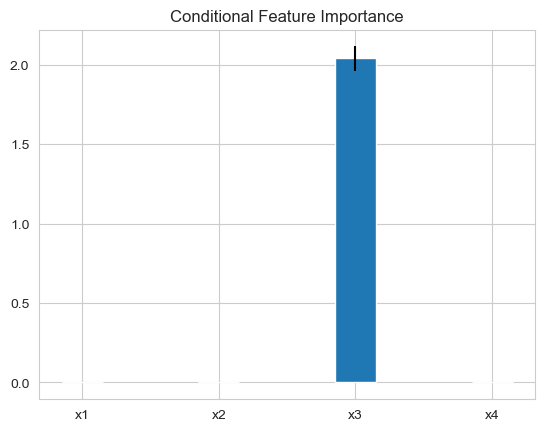

In [31]:
# plot cfi scores
cfi_plot = plot_scores(
    feature_names=X_test.columns,
    scores=cfi_mean,
    scores_std=cfi_std,
    title='Conditional Feature Importance')

Now, only $X_3$ is considered relevant.

**Question:** Considering the different interpretation goals discussed in the lecture, what can we infer from the plot?

**Answer:** For CFI, each feature will only be permute in a certain distribution with respect to other features. This will not "break" the relationship between $X_1$ and $X_2$, overcoming the problem of PFI. Let's visualize when $X_2$ is permute, we can see that the permute value of x2 will not be too much "different" from the original value $X_2$. That is, it still retains the relationship with x1 in this case.

| Index | Permute X2 | Original X2 |
|:-----:|:----------:|-------------|
|   38  |  -0.218442 | -0.206902   |
|  727  |  0.524151  | 0.539641    |
|  847  |  -0.903120 | -0.901189   |
|  296  |  1.027771  | 1.011964    |
|  925  |  -1.071002 | -1.051182   |
|  ...  |     ...    | ...         |
|  895  |  0.545342  | 0.548076    |
|  541  |  -0.657785 | -0.655207   |
|  568  |  -0.222531 | -0.218663   |
|  642  |  -1.037748 | -1.022398   |
|  130  |  -0.967016 | -0.969797   |


## Part 3: Leave One Covariate Out (LOCO)

Finally, we want to implement Leave One Covariate Out (LOCO). Fill in the function *calculate_loco()*, such that it iterates over the columns in X_test, and for each feature fits a model on the data without the current feature and calculates the corresponding LOCO score for the feature based on the mean-squared-error loss. Hint: You can use clone(model) to make a copy of a sklearn model.

In [32]:
from sklearn.base import clone

def calculate_loco(model, X_test, y_test, mse_test, X_train, y_train):
    """Iterates over all features in X_test and calculates the corresponding LOCO score based on leaving the feature out and refitting the model.

    Args:
        model: trained model
        X_test: feature values of test data
        y_test: respective labels for test data
        mse_test: MSE on unpertubed test data
        X_train: feature values of train data
        y_train: respective labels for train data

    Returns:
        results (list or 1D np.ndarray): LOCO score for each feature in X_test
    """
    #init loco
    loco = []
    
    #loop through the features and permute
    for col in X_test.columns:
        col_loco = [i for i in X_test.columns if i is not col]
        X_train_loco = X_train[col_loco]
        X_test_loco = X_test[col_loco]
        
        model.fit(X_train_loco,y_train)
        y_pred_loco = model.predict(X_test_loco)
        mse_permute = mean_squared_error(y_test,y_pred_loco)
        delta_L = mse_permute - mse_test
        loco.append(delta_L)

    return loco

In [33]:
# calculate leave one covariate out
loco_score = calculate_loco(model, X_test, y_test, mse_test, X_train, y_train)

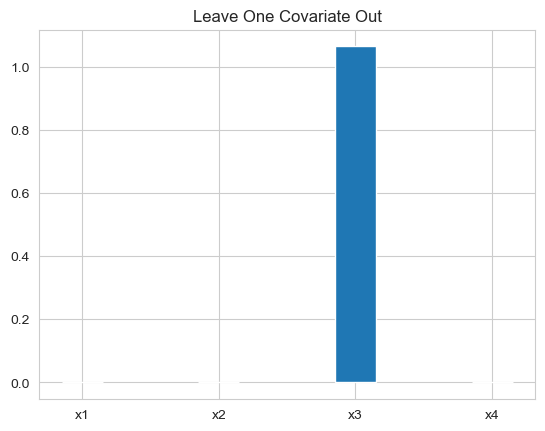

In [34]:
# plot leave one covariate out
loco_plot = plot_scores(
    feature_names=X_test.columns,
    scores=loco_score,
    title='Leave One Covariate Out')

Result is similar as for CFI: only feature $X_3$ is considered relevant.

**Question:** Considering the different interpretation goals discussed in the lecture, what can we infer from the plot?

**Answer:** Unlike FPI and CFI, LOCO completely removes the feature to calculate its importance by retraining the model without the feature itself. This approach does not need to consider the distribution of a feature with respect to other features. However, LOCO will consume a lot more resources than the above two approaches.